# Digit recognition using Keras CNN

## 1. Introduction**
## 2. Data preparation**
## 3. CNN** -Modelling and Prediction

# 1. Introduction

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tenrsorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

I achieved 99.671% of accuracy with this CNN trained in 2h30 on a single CPU (i5 2500k). For those who have a >= 3.0 GPU capabilites (from GTX 650 - to recent GPUs), you can use tensorflow-gpu with keras. Computation will be much much faster !!!

**For computational reasons, i set the number of steps (epochs) to 3 **

This Notebook follows three main parts:

* The data preparation
* The CNN modeling and evaluation
* The results prediction and submission

## 1.1 Goal of this project: 
<img src="presentation_images/summary_image.png">

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2. Data preparation


## Example image -> data
<img src="presentation_images/sample_grid_a_square.png">

## 2.1 Load data

- The most common pixel format is the byte stored as an 8-bit integer 
- Range of possible values from 0 to 255. 
- Typically zero is taken to be black, and 255 is taken to be white. 

In [5]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 



1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

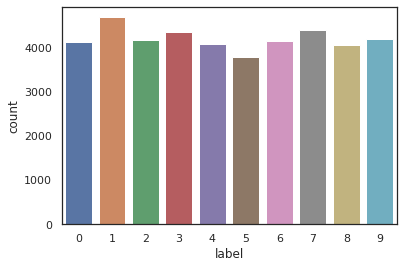

In [7]:
g = sns.countplot(Y_train)

Y_train.value_counts()

We have similar counts for the 10 digits.

## 2.2 Check for null and missing values

In [8]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [10]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 2.3 Reshape

In [11]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices. 

## 2.5 Label encoding

In [12]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

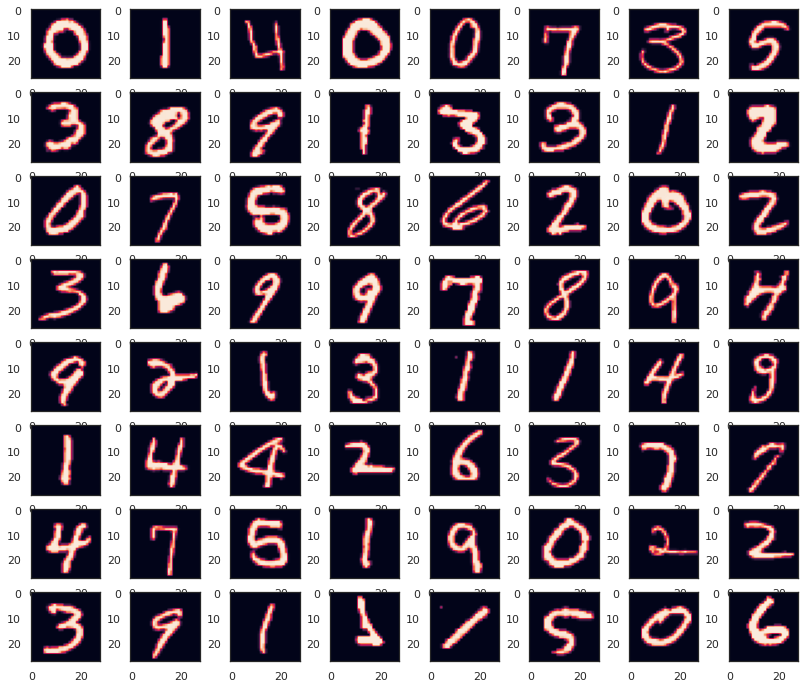

In [14]:
# Some examples
# print(X_train[0])
plt.figure(figsize=(14,12))
for i in range(1, 65):
    plt.subplot(8, 8, i)
    plt.imshow(X_train[i][:,:,0])

# 3. Modelling and Prediction using Keras - CNN

## 3.1 Base Model  

### Choosen Parameters
- Data Split: 70% Train  30% Test,
- Epoch = 1, batchsize = 86, learning rate = 0.001

### Prediction Result: Accuracy 98.60 % 
<img src="presentation_images/result_1.png">

### 3.1.1 Split Data

In [ ]:
# Set the random seed
random_seed = 2
split_size = 0.3

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = split_size, random_state=random_seed)

### 3.1.2. Create Model  

<img src="presentation_images/cnn.png">

#### I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

#### The first is the convolutional (Conv2D) layer:
It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

#### The second important layer in CNN is the pooling (MaxPool2D) layer:

This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important. 

#### Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

Rectified Linear Unit(RELU)  is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

### 3.1.3. Set the optimizer and annealer

Once our layers are added to the model, we need to set: 

- Score Function
- Loss Function 
- Optimisation Algorithm.

#### Loss function : Measures how poorly our model performs on images with known labels. 

It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

#### Optimizer(RMSprop): Iteratively improves parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. 

RMSprop (with default values): Adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.

Stochastic Gradient Descent ('sgd') is an another optimizer , but it is slower than RMSprop.


#### Metric function "accuracy" is used is to evaluate the performance our model.
This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#### Learning Rate (LR): To make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

###  3.1.4. Prediction

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (X_val, Y_val), verbose = 2)

## 3.2 Modifying the base model to improve accuracy 

### Modification : Augmented the data used in the base model

### Result: Prediction accuracy increased to  99.08%
<img src="presentation_images/result_data_aggregation.png">

### 3.2.1 Data augmentation 

#### For the data augmentation, i choosed to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height

#### Once our model is ready, we fit the training dataset .

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

### 3.2.2 Prediction

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])